# Décomposition en contributions additives - Partie 3

In [1]:
# Il est nécessaire d'ajouter le chemin du projet au python path,
# pour pouvoir utiliser les ressources mises à disposition.

########## A vous de jouer
# Modifiez le path de manière à ce qu'il corresponde à votre ordinateur.
import sys
sys.path.append('/Users/jms/prod/20181003_Technical_training_interpretability')

#sys.path.append('/home/VOTRE_IDENTIFIANT-FED/LE_CHEMIN_CHOISI/')

## 1. Import du modèle et des données

In [2]:
import pickle

with open('data_model_rf.pickle', 'rb') as handle:
    data_model_dict = pickle.load(handle)

X_train, X_test, y_train, y_test, model = data_model_dict.values()
f_predict = lambda x: model.predict_proba(x)[:,1]

/Users/jms/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jms/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jms/prod/20181003_Technical_training_interpretability/.venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
## Exemple : Une prédiction pour 10 échantillons aléatoires du jeu de test:
f_predict(
    X_test.sample(10, random_state=42)
)

array([0.33058554, 0.54339778, 0.25560691, 0.54657462, 0.0544803 ,
       0.77699009, 0.78250217, 0.31317756, 0.59730188, 0.76966065])

## 2. SHappley Additive exPlaination (SHAP)

SHAP (SHapley Additive exPlanations) est une méthode unifiée pour expliquer les sorties d'un modèle de machine learning. En utilisant la théorie des jeux sur des explications locales, plusiuesr méthodes (LIME, treeinterpreter) sont unifiées par une méthode de calcul consistante basée sur les valeurs de Shapley.
En effet, le problème de certaines méthodes de calcul de contribution (treeinterpreter) est d'être trop sensible à l'ordre dans lequel les variables "apparaissent". 

In [4]:
%%time
import shap
import pandas as pd

## Apply Tree Shap to the model on testing set
explanation = shap.TreeExplainer(model)

# Ci-dessous, le [1] est nécessaire pour les classifiers (il récupère la classe "1")
# Pour les régression, il est nécessaire de l'enlever.

shap_values = explanation.shap_values(X_test)[1]
df_contrib = pd.DataFrame(shap_values,
                           columns=X_test.columns,
                           index=X_test.index)
bias = explanation.expected_value[1]

CPU times: user 474 ms, sys: 202 ms, total: 676 ms
Wall time: 7.35 s


### 2.1. Plots par défaut de la librairie

La documentation est disponible sur le github de la librairie et fournit un bon nombre d'exemple de manipulation de données : https://github.com/slundberg/shap.

In [5]:
shap.initjs()

# Interprétabilité locale : explorer une prédiction
n_sample = 9

shap.force_plot(bias,
                shap_values[n_sample,:],
                X_test.iloc[n_sample,:])


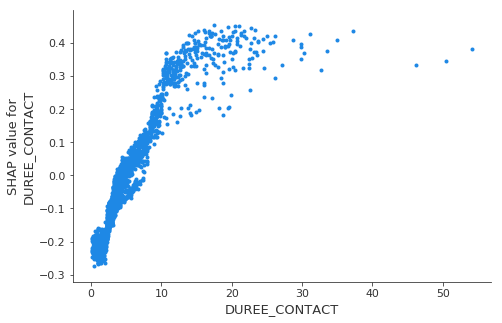

In [6]:
# Cette visualisation porte beaucoup de sens pour les variables continues.

# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("DUREE_CONTACT", shap_values, X_test, interaction_index=None)

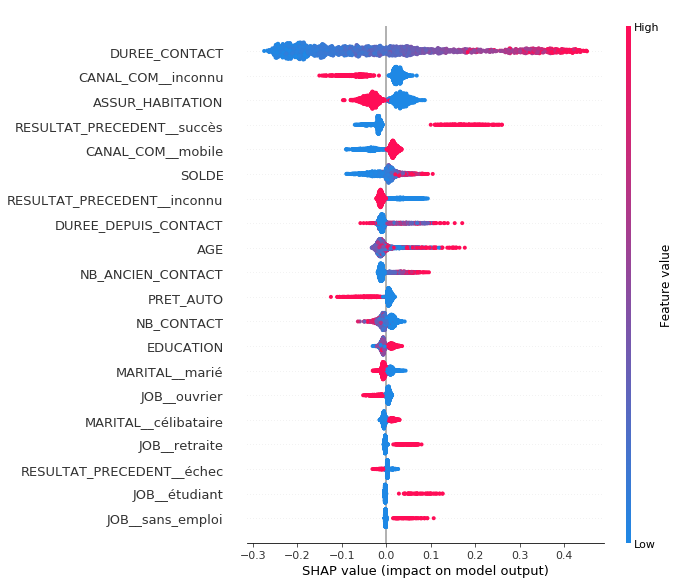

In [7]:
# La figure récapitulative.

shap.summary_plot(shap_values, X_test)

### 2.2. Plots personnalisés, avec ré-agrégation des variables dummifiées

L'inconvénient des visualisations précédentes est de ne pas traiter les variables catégorielles en tant que telles, mais de les traiter comme une multiplicité des variables dummifiées.

Ainsi, l'effet des contributions sur plusieurs variables dummifiées est en quelque sorte dilué et plus compliqué à comprendre. La transformation que nous allons réaliser consiste à sommer les contributions des variables dummifiées et les associer à chaque fois à la modalité correspondante.

In [8]:
# Apply postprocessing steps to correctly interpret dummy variables
from useful_functions import prepare_interpretable_contribution, plot_observation_contribution, plot_single_feature

interpretable_dict = prepare_interpretable_contribution(X_test, f_predict, df_contrib, bias)

In [9]:
## Plot contributions for one consumer (local interpretability)
%matplotlib inline 
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode(connected=True)



########## A vous de jouer
# Explorez les prédictions pour différents individus et comparer la visualisation précédente
# Modifiez les paramètres pour changer le nombre de feature à représenter (num_features_plot) et 
# la variable is_horizontal.
# Quelle est votre préférence ? 



fig = plot_observation_contribution(
    interpretable_dict,
    9, # You can change this parameter to change the consumer.
    num_features_plot=4,
    is_horizontal=True
    )

offline.iplot(fig)

In [10]:
## Plot contributions for one variable (global interpretability)

########## A vous de jouer
# Modifiez les paramètres pour changer le nom de la variable.
# Le cas présenté ici est une variable catégorielle (qui n'est pas accessible en tant que telle,
# sans la ré-agragation). Essayez des variables continues.
# Quelle est votre préférence entre cette représentation et la précédente ? 

fig = plot_single_feature(
    interpretable_dict,
    variable='JOB', # You can change this parameter to change the variable.
    max_sample_size=3000)  # Numbers of points to plot.

offline.iplot(fig)

Cependant, SHAP est très lent quand il ne s'applique pas à un modèle d'ensembling d'arbres. En effet, dans le cas général, on ne peut utiliser ```TreeExplainer``` et c'est la méthode générale ```KernelExplainer``` qui est exécutée mais qui est beaucoup moins rapide.

In [11]:
%%time

## Don't run it, it takes 40 minutes !


# ## Apply Tree Shap to the model on testing set
# explanation = shap.KernelExplainer(f_predict, shap.kmeans(X_train, 10)) #The Kernel is computed using the training set.
# 
# # Ci-dessous, le [1] est nécessaire pour les classifiers (il récupère la classe "1")
# # Pour les régression, il est nécessaire de l'enlever.
# 
# shap_values = explanation.shap_values(X_test)[1]
# df_contrib = pd.DataFrame(shap_values,
#                            columns=X_test.columns,
#                            index=X_test.index)
# bias = explanation.expected_value[1]

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs
